In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.tiling import *

# Tile raw data

In [2]:
tile_path = '../../deadwood/data/Sudenpesänkangas_crop.tif'
annot_shp_path = '../../deadwood/data/both_qgis.shp'

In [3]:
import geopandas as gpd
ann = gpd.read_file(annot_shp_path)
ann['label_id'] = ann.apply(lambda row: 1 if row.label == 'Fallen' else 2, axis=1)
ann.to_file(annot_shp_path)

In [4]:
tiler = Tiler('../data/analysis_data', 400, 400, (100,100))

Make raster tiles

In [5]:
tiler.tile_raster(tile_path)

0it [00:00, ?it/s]

Make vector tiles

In [6]:
tiler.tile_vector(annot_shp_path)

0it [00:00, ?it/s]

Rasterize masks for U-Net and such.

In [26]:
??tiler.tile_and_rasterize_vector

In [28]:
tiler.tile_and_rasterize_vector('label_id')

0it [00:00, ?it/s]

# Shapefiles to coco annotations

In [8]:
from drone_detector.coco import *

In [9]:
deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'Standing'},
        {'supercategory':'deadwood', 'id':2, 'name': 'Fallen'},
    ]

In [10]:
from datetime import date

coco_info = {'description': 'Dataset for deadwood detection',
             'version': 0.1,
             'year': 2021,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

In [11]:
coco_processor = COCOProcessor('../data/analysis_data/', 
                               '../data/analysis_data/', 
                               coco_info, 
                               coco_licenses, 
                               deadwood_categories)

In [12]:
coco_processor.shp_to_coco()

  0%|          | 0/819 [00:00<?, ?it/s]

# Examine coco annotations

In [13]:
from icevision.all import *

In [14]:
parser = parsers.COCOMaskParser('../data/analysis_data/coco.json', img_dir='../data/analysis_data/raster_tiles/')
class_map = ClassMap(['Standing deadwood', 'Fallen deadwood'])

In [15]:
records = parser.parse(data_splitter=SingleSplitSplitter())[0]

  0%|          | 0/4044 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/819 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 28) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:0.0, ymin:-2.9802322387695312e-08, xmax:29.180344700813293, ymax:37.450709730386734)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 29) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:217.91316918097436, ymin:-2.9802322387695312e-08, xmax:351.4414720470086, ymax:228.48756048083305)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 29) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:259.1750979460776, ymin:-2.9802322387695312e-08, xmax:349.2425223691389, ymax:98.91128626465797)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 29) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:328.7530194055289, ymin:-2.9802322387695312e-08, xmax:400.0, ymax:63.28201246261597)>)) | icevision.utils.logger_utils:autofix_l

AUTOFIX-SUCCESS - (record_id: 430) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:307.86875058244914, ymin:-2.9802322387695312e-08, xmax:337.9705676427111, ymax:50.67731848359108)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 430) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:59.87185625452548, ymin:-2.9802322387695312e-08, xmax:73.56669163797051, ymax:7.451094269752502)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 472) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:250.57105147559196, ymin:-2.9802322387695312e-08, xmax:372.3691555839032, ymax:256.76739978790283)>)) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 523) - Clipping bbox ymin from -2.9802322387695312e-08 to 0 (Before: (<BBox (xmin:0.0, ymin:-2.9802322387695312e-08, xmax:49.24252237007022, ymax:58.43956929445267)>)) | icevision.utils.logger_

In [16]:
ix = random.randint(0, (len(records)-9))
show_records(records[ix:ix+9], ncols=3, class_map=class_map, display_bbox=False, display_label=False)

In [17]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
train_ds = Dataset(records, train_tfms)

In [18]:
samples = [train_ds[random.randint(0, len(records))] for _ in range(12)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, display_bbox=False)

# Examine semantic segmentation dataset

In [6]:
from fastai.vision.all import *
from drone_detector.visualizations import *
from drone_detector.data import *

def label_func(fn): return f'../data/analysis_data/rasterized_vector_tiles/{fn.stem}{fn.suffix}'

fnames = [Path(f'../data/analysis_data/raster_tiles/{f}') for f in 
          os.listdir('../data/analysis_data/rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   batch_tfms= [
                                                       Normalize.from_stats(*imagenet_stats)
                                                   ])

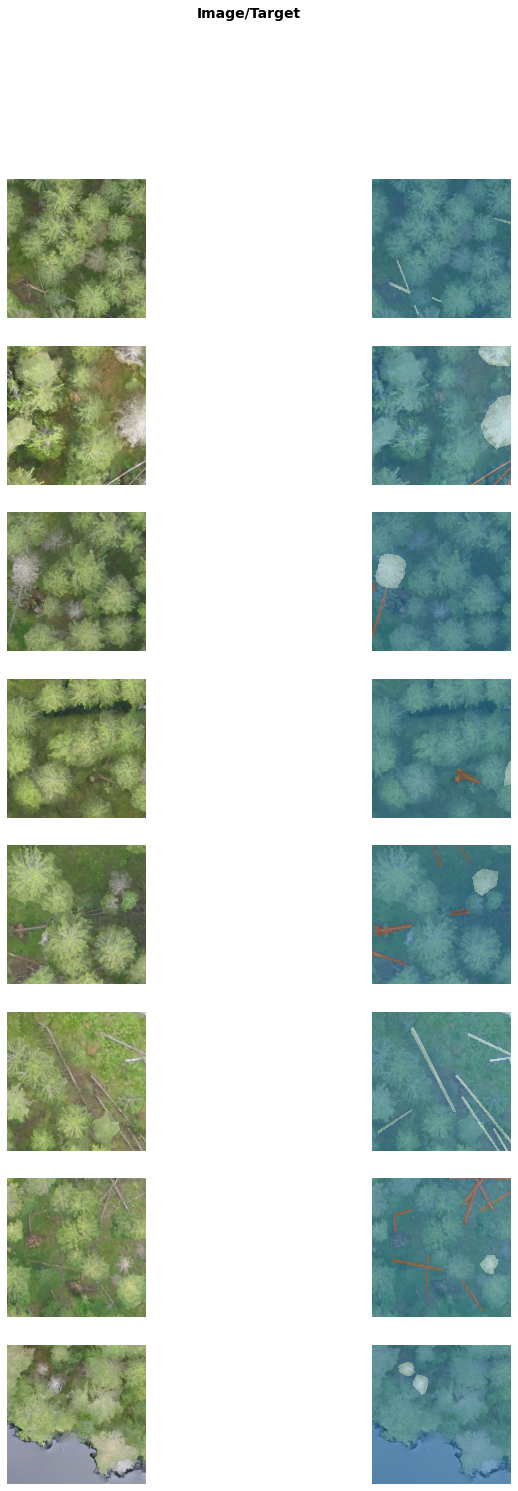

In [8]:
deadwood.show_batch(max_n=16)